In [115]:
# Import libraries
import pandas as pd
# pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet
from pylab import rcParams
import calendar

In [2]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
# Fill missing values
df = df.fillna(0)

In [4]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [5]:
# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.to_datetime(df_reshaped['Date']) 
df_reshaped = df_reshaped.set_index('Date')

## Time series analysis

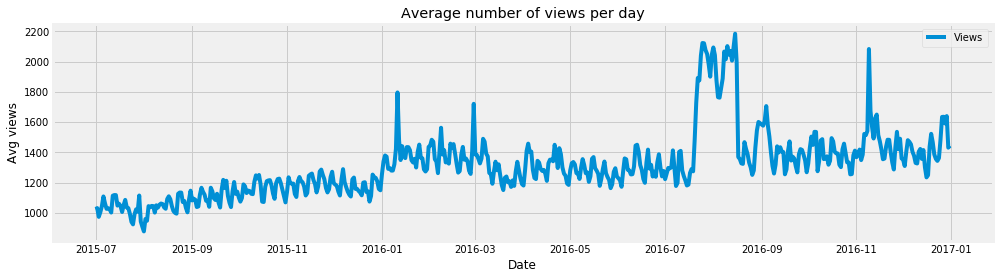

In [6]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

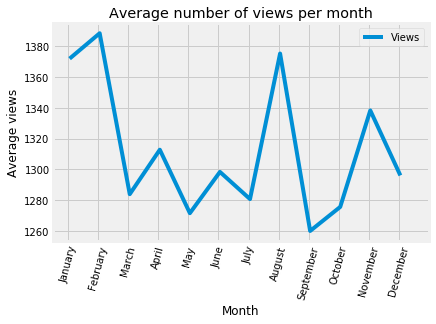

In [7]:
# Average number of views per month
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
ax.set_title('Average number of views per month')
plt.show()

In [ ]:
weekday_index = df_reshaped.index.weekday_name
views_by_weekdays = df_reshaped.groupby(weekday_index).sum()

ax = views_by_weekdays.plot()
#start, end = ax.get_xlim()
#plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
#ax.set_xticklabels(months,rotation=75)
#ax.set_xlabel('Month')
ax.set_ylabel('Total views')
plt.show()

In [ ]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
temp1 = df_reshaped  
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

In [ ]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df.head()
# lang_df = lang_df[lang_df['Page_language']!='None']
# # lang_df['Views'] = round(lang_df['Views']/1000000,0)

# bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
# bar_graph.set_ylabel('Total views (in millions)')
# bar_graph.set_title('Total number of views based on language of webpage')

# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+500))
# ax.legend()
# plt.show()

In [ ]:
df_reshaped['Dayofweek'] = df_reshaped.Date.dt.dayofweek

def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
df_reshaped['Dayofweek'] = df_reshaped.Dayofweek.apply(find_day)

In [ ]:
day = df_reshaped.groupby('Dayofweek')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [50]:
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages.nlargest(5,'Views')

,Page,Views
58761,Main_Page_en.wikipedia.org_all-access_all-agents,1.206618e+10
58763,Main_Page_en.wikipedia.org_desktop_all-agents,8.774497e+09
58764,Main_Page_en.wikipedia.org_mobile-web_all-agents,3.153985e+09
93891,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,1.603934e+09
82337,Special:Search_en.wikipedia.org_all-access_all...,1.304079e+09


In [51]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(['Main_Page_en.wikipedia.org_all-access_all-agents','Main_Page_en.wikipedia.org_desktop_all-agents','Main_Page_en.wikipedia.org_mobile-web_all-agents','Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents','Special:Search_en.wikipedia.org_all-access_all-agents'])]

In [ ]:
for i in list(top5_pages_df.Page.unique())[:5]:
    ax = top5_pages_df.loc[top5_pages_df.Page == i,:].plot(label=i)
ax.set_ylabel('Views')
plt.legend(loc='upper left')
plt.show()

In [52]:
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])

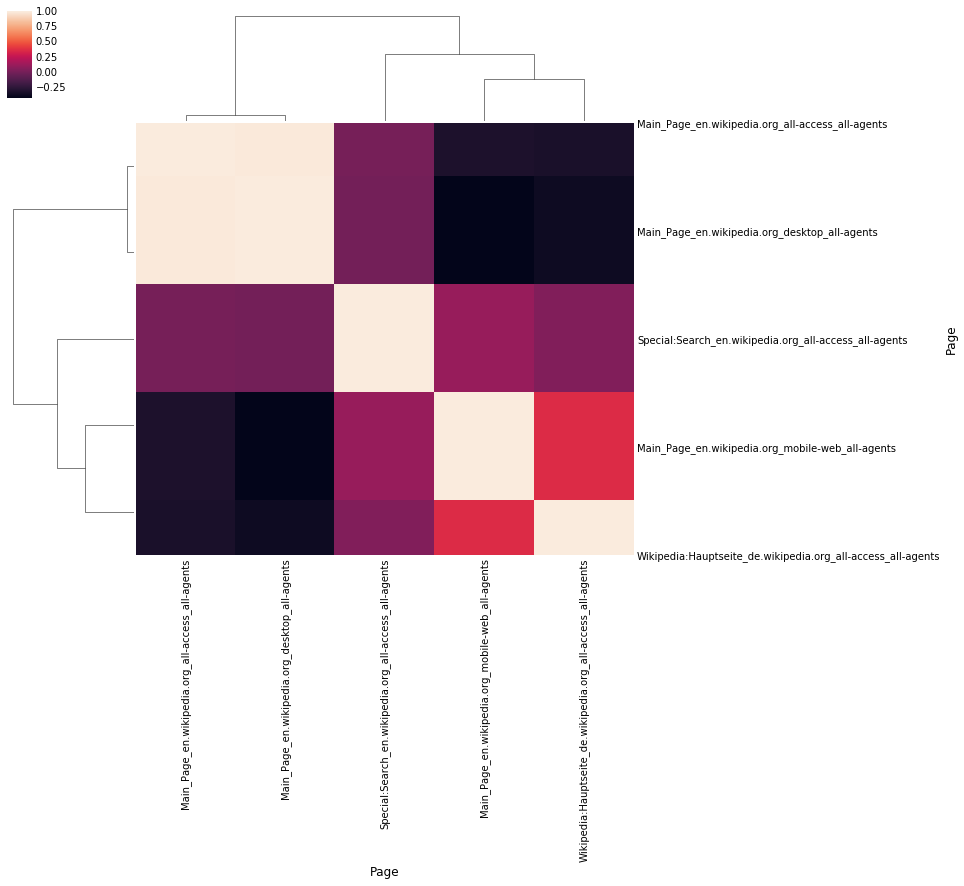

In [53]:
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [54]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


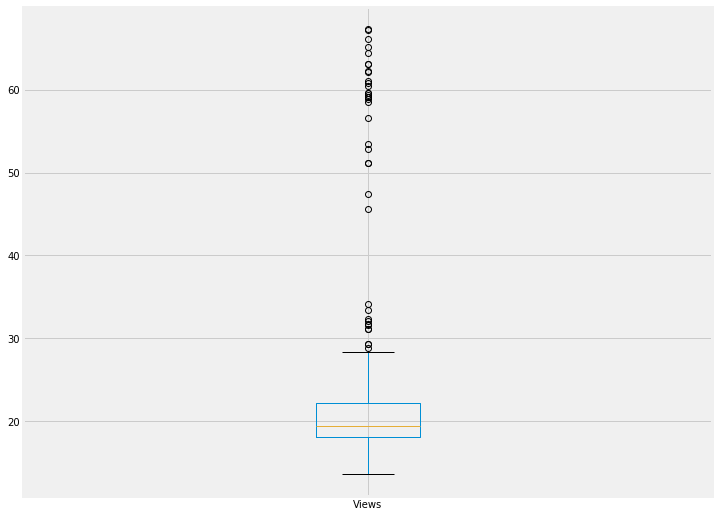

In [55]:
ax1 = top_page_df.boxplot()

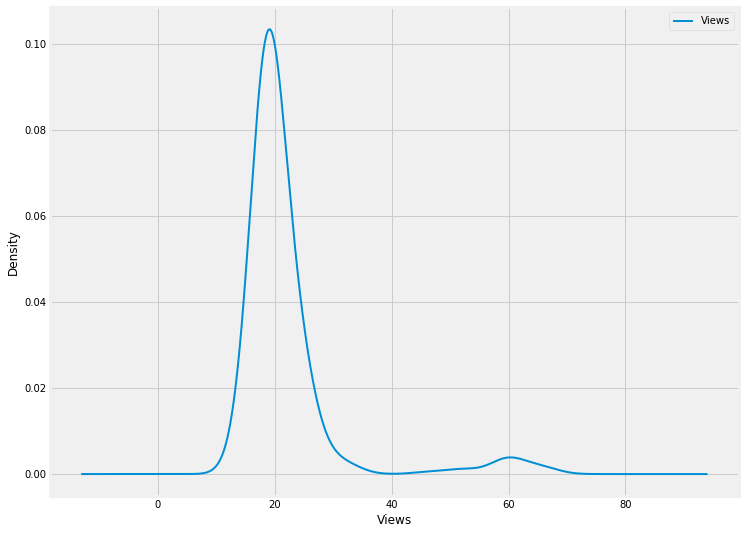

In [56]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

## Anomaly detection using Isolation Forest

In [57]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



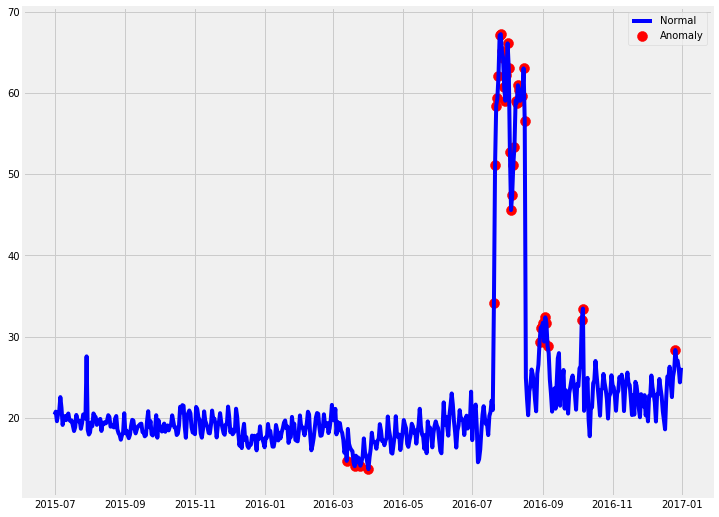

In [58]:
fig, ax = plt.subplots(figsize=(11,9))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Views'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Views'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

In [59]:
top_page_df = top_page_df[top_page_df['anomaly']==1]
top_page_df.drop(columns=['anomaly'],inplace=True)

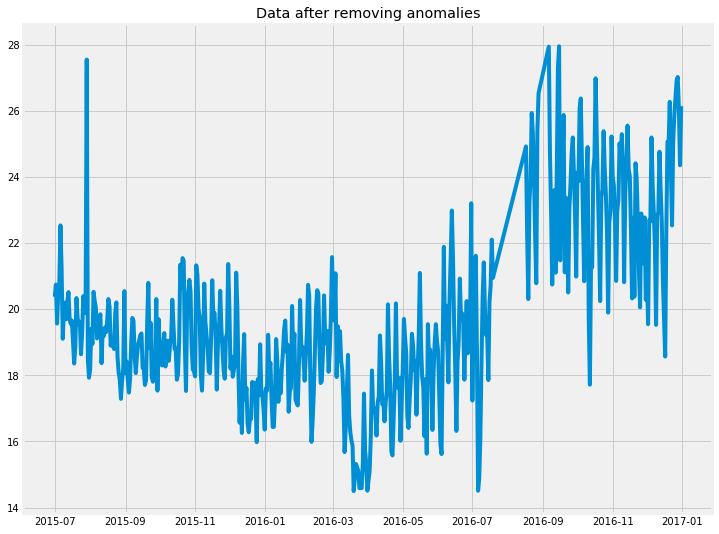

In [60]:
plt.figure(figsize=(11,9))
plt.plot(top_page_df,label='Views')
plt.title('Data after removing anomalies')
plt.show()

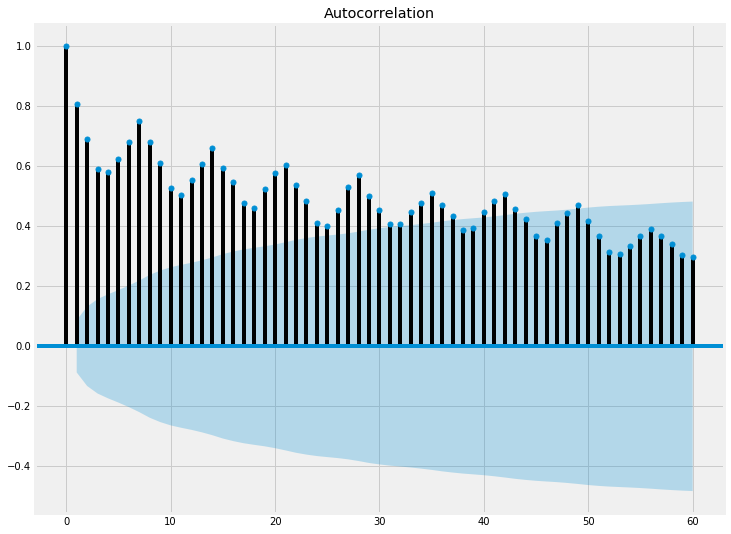

In [61]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

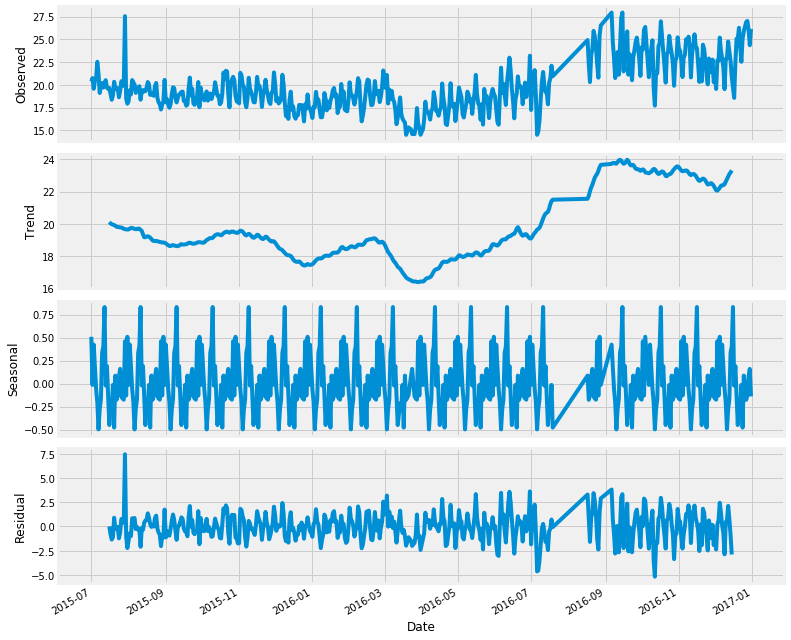

In [62]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df['Views'],freq = 30)
figure = ts_decomposition.plot()
plt.show()

## Augmented Dicky-Fuller test

In [63]:
test = adfuller(top_page_df['Views'])
print(test)

(-0.5684144613467819, 0.8779605467626828, 18, 487, {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}, 1652.2613880336276)


 0th element is the test statistic. Since the value is approximately -3, we can say that the data is more likely to be stationary.
 1st element indicates the p-value. Since the p-value is < 0.05, we can reject null hypothesis.

In [64]:
top_page_stationary_df = top_page_df.diff().dropna()
top_page_stationary_df.head()

,Views
Date,
2015-07-02,0.37
2015-07-03,-1.18
2015-07-04,0.87
2015-07-05,0.33
2015-07-06,1.77


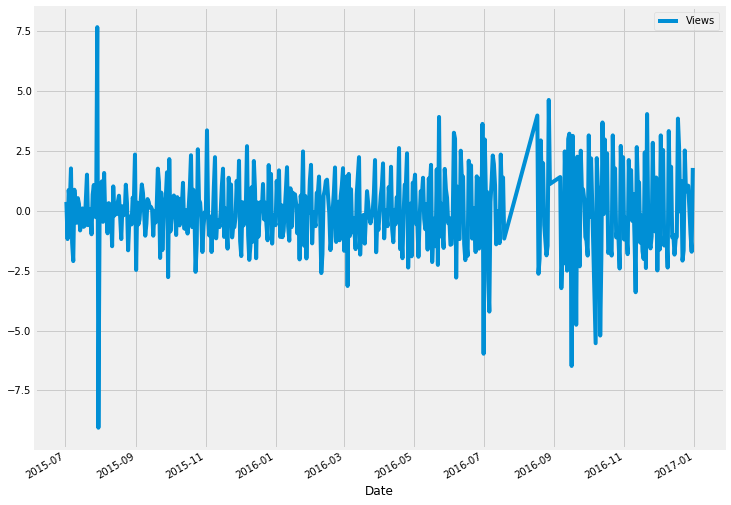

In [65]:
ax = top_page_stationary_df.plot()
plt.show()

In [66]:
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-6.347191806503063, 2.6649916563864804e-08, 17, 487, {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}, 1648.0126912832893)


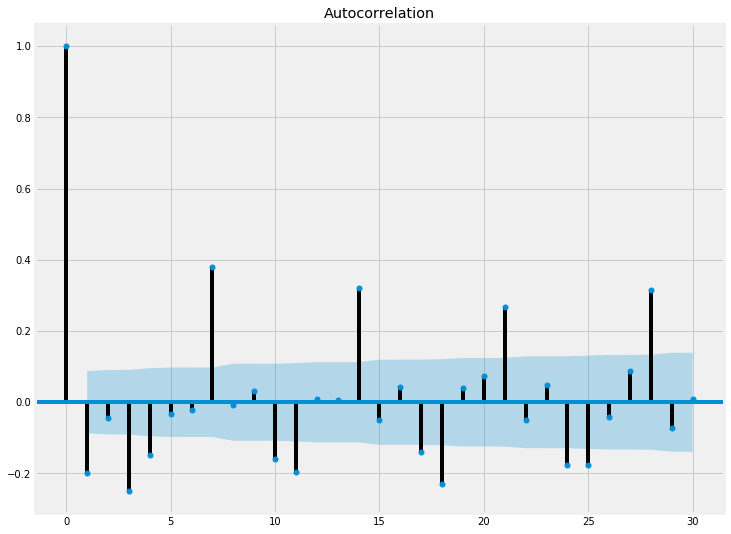

In [67]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

## Modelling

In [68]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

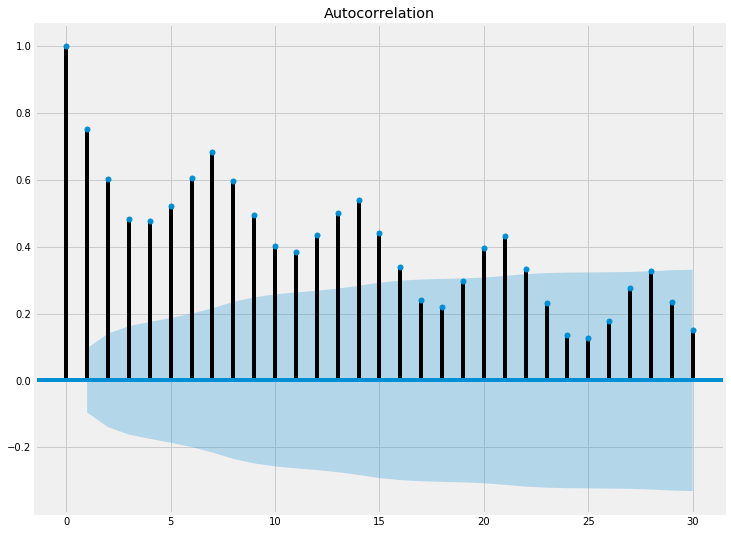

In [69]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

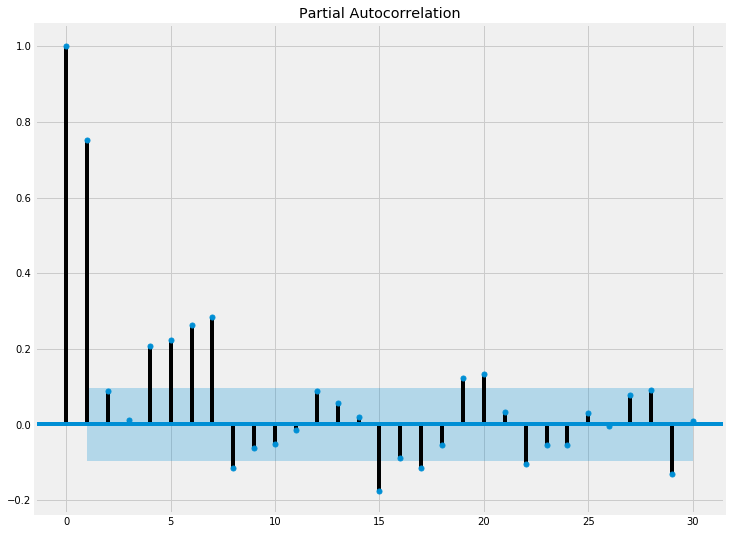

In [70]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

In [29]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
            print(p, q, result.aic, result.bic)
        except:
#             continue
            print(p,q,None,None)


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



0 0 3694.728189533469 3698.7708223671516


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0 1 3232.4900234953584 3240.575289162723
0 2 2912.6445224828285 2924.7724209838757


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0 3 2735.256630368076 2751.4271617028057


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0 4 2594.58686050247 2614.8000246708816


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0 5 2496.008442538253 2520.2642395403473


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0 6 2439.7420067280195 2468.040436563796
1 0 2109.980105209642 2118.0653708770064


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



1 1 1952.5146672071437 1964.642565708191
1

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



 2 1943.4800860774085 1959.650617412138
1 3 None None
1 4 None None
1 5 None None
1 6 None None
2 0 2038.8188239797246 2050.9467224807718


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueW

2 1 1942.302896244365 1958.4734275790945


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



2 2 1944.2870890143777 1964.5002531827895
2 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



2 4 1941.953714682816 1970.2521445185928
2 5 None None
2 6 None None
3 0 2025.9576843862128 2042.1282157209423


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



3 1 1944.2629344275015 1964.4760985959133
3 2 None None
3 3 None None
3 4 None None
3 5 None None
3 6 None None
4 0 2003.158638950642 2023.3718031190538


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueW

4 1 1938.2054814747194 1962.4612784768137
4 2 None None
4 3 None None
4 4 None None
4 5 None None
4 6 None None
5 0 1988.2453522061858 2012.5011492082801


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueW

5 1 1937.8522592016257 1966.1506890374023
5 2 None None
5 3 None None
5 4 None None
5 5 None None
5 6 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueW

6 0 1960.8296414160723 1989.128071251849


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



6 1 1934.5276038378984 1966.8686665073574


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



6 2 1937.17573651567 1973.5594320188113
6 3 None None
6 4 None None
6 5 None None
6 6 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no as

In [90]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values('aic')

In [91]:
aic_bic_df.head()

,p,q,aic,bic
21,6,1,1934.527604,1966.868667
22,6,2,1937.175737,1973.559432
19,5,1,1937.852259,1966.150689
17,4,1,1938.205481,1962.461278
13,2,4,1941.953715,1970.252145


In [ ]:
int(aic_bic_df.iloc[0]['q'])

## Fitting ARMA model

In [92]:
model = SARIMAX(train,order=(4,0,1))
result = model.fit()

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [93]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean

In [94]:
forecast_mean

Date
2016-08-24    23.555468
2016-08-25    22.748298
2016-08-26    22.277369
2016-08-27    21.919356
2016-08-28    24.849150
2016-09-06    25.771547
2016-09-07    25.332037
2016-09-08    23.753252
2016-09-09    22.768698
2016-09-10    22.621061
2016-09-11    24.189501
2016-09-12    24.667604
2016-09-13    22.275698
2016-09-14    23.696085
2016-09-15    26.145332
2016-09-16    25.726120
2016-09-17    21.677281
2016-09-18    23.554282
2016-09-19    25.416365
2016-09-20    25.082553
2016-09-21    22.586336
2016-09-22    23.341291
2016-09-23    24.296670
2016-09-24    22.023081
2016-09-25    23.346796
2016-09-26    24.238738
2016-09-27    23.861613
2016-09-28    24.056120
2016-09-29    23.431928
2016-09-30    22.814658
dtype: float64

In [95]:
confidence_interval = forecast.conf_int()
confidence_interval.head()

,lower Views,upper Views
Date,,
2016-08-24,20.978175,26.132760
2016-08-25,20.171005,25.325590
2016-08-26,19.700076,24.854662
2016-08-27,19.342064,24.496649
2016-08-28,22.271857,27.426443


## Predicting the number of views for the last 30 days using ARMA model

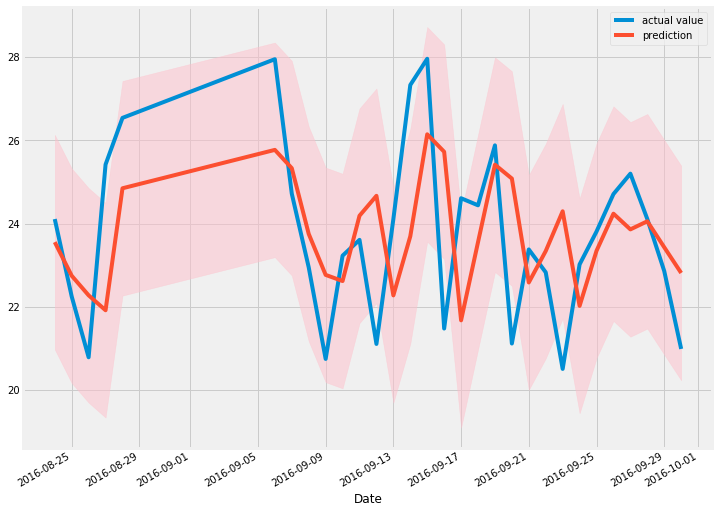

In [96]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

### Forecasting using ARMA model

In [97]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [98]:
arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})

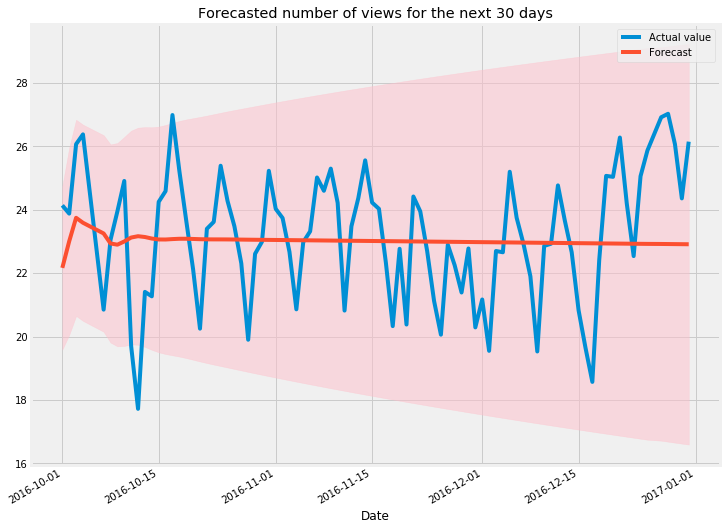

In [99]:
fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df.plot(x='Date',y='Views',label='Forecast',ax=ax)
plt.fill_between(arma_forecast_df.Date, \
                arma_forecast_df['lower_views'], \
                arma_forecast_df['upper_views'], \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [100]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

RMSE: 2.0390957596419375


## ARIMA model

In [89]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
print(arima_aic_bic_df.sort_values(['aic','bic']))

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency informa

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\sit

    p  q          aic          bic
41  6  5  1358.028316  1406.396539
29  4  6  1360.789789  1405.127327
34  5  5  1361.577319  1405.914857
28  4  5  1362.536490  1402.843343
20  3  3  1363.217170  1391.431966
35  5  6  1363.473203  1411.841426
15  2  4  1363.620216  1391.835013
14  2  3  1364.276630  1388.460742
16  2  5  1364.339723  1396.585205
42  6  6  1365.138973  1417.537882
17  2  6  1365.750423  1402.026590
32  5  3  1366.554127  1402.830294
27  4  4  1366.953330  1403.229497
22  3  5  1367.618337  1403.894504
26  4  3  1367.677617  1399.923099
21  3  4  1367.810385  1400.055867
23  3  6  1368.210559  1408.517412
33  5  4  1368.697091  1409.003943
40  6  4  1372.194141  1416.531679
39  6  3  1373.253622  1413.560475
37  6  1  1377.027775  1409.273257
36  6  0  1377.292729  1405.507526
38  6  2  1378.512386  1414.788554
31  5  1  1399.728510  1427.943307
25  4  1  1411.464553  1435.648664
19  3  1  1419.513506  1439.666932
30  5  0  1421.311200  1445.495311
12  1  6  1423.57682

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [101]:
arima_model = SARIMAX(train,order=(2,1,4))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



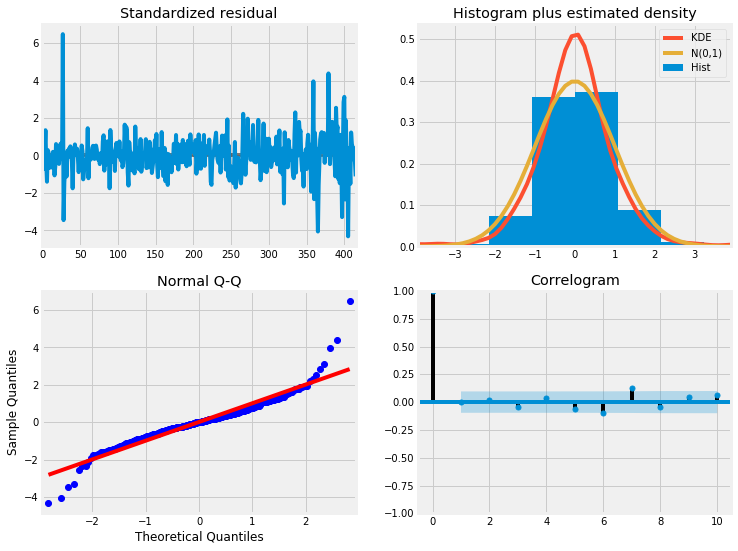

In [102]:
arima_result.plot_diagnostics()
plt.show()

In [103]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Views   No. Observations:                  417
Model:               SARIMAX(2, 1, 4)   Log Likelihood                -674.810
Date:                Fri, 22 May 2020   AIC                           1363.620
Time:                        23:29:53   BIC                           1391.835
Sample:                             0   HQIC                          1374.776
                                - 417                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2394      0.009    139.891      0.000       1.222       1.257
ar.L2         -0.9898      0.009   -109.641      0.000      -1.008      -0.972
ma.L1         -1.8061      0.033    -55.194      0.000      -1.870      -1.742
ma.L2          1.5590      0.066     23.657      0.000       1.430       1.688
ma.L3         -0.4668      0.073     -6.365      0.000      -0.611      -0.323
ma.L4         -0.0795      0.040     -1.968      0.049      -0.159      -0.000
sigma2         1.4912      0.054     27.376      0.000       1.384       1.598
===================================================================================
Ljung-Box (Q):                       67.87   Jarque-Bera (JB):               769.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

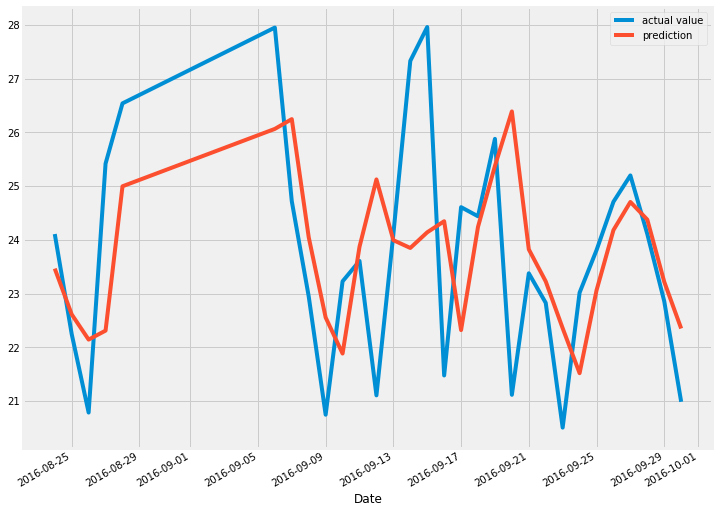

In [104]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

### Forecasting using ARIMA model

In [105]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [107]:
arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})

In [108]:
arima_forecast_df.head()

,Date,Views,lower_views,upper_views
417,2016-10-01,21.893223,19.499819,24.286628
418,2016-10-02,22.928483,20.319981,25.536985
419,2016-10-03,23.982831,21.277120,26.688542
420,2016-10-04,24.373338,21.612479,27.134197
421,2016-10-07,23.813751,21.014221,26.613281


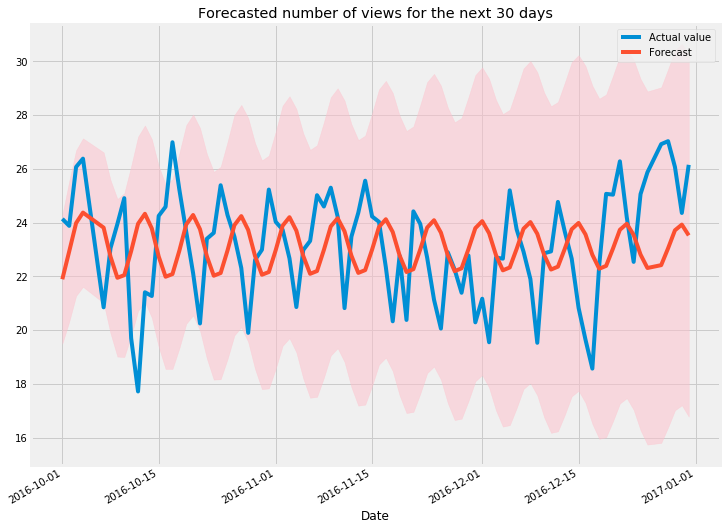

In [110]:
fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arima_forecast_df.plot(x='Date',y='Views',ax=ax,label='Forecast')
plt.fill_between(arima_forecast_df.Date, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [112]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))

RMSE: 2.3744655088516713


## Exponential smoothing model

In [133]:
train.index = pd.DatetimeIndex(train.index)
start_date=train[-30:-29].index[0].date()
str_start_date = start_date.strftime("%Y-%m-%d")
end_date=train[-1:].index[0].date()
str_end_date = end_date.strftime("%Y-%m-%d")
# print(date_time)
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)
exp_smoothing_prediction = exp_smoothing_result.predict(start=str_start_date,end=str_end_date)
plt.plot(train[-30:], label='Train')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

In [131]:
# df['Date'] = [datetime.datetime.date(d) for d in df['DateTime']] 
# val= str(datetime.date(train[-30:-29].index[0]))
# print(val)
t=train[-30:-29].index[0].date()
date_time = t.strftime("%Y-%m-%d")
print(date_time)

2016-08-24


### Forecasting using Exponential Smoothing model

In [ ]:
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])
plt.plot(top_page_filtered)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))

## Prophet

In [ ]:
ptrain = b[:'2016-09']
ptest = b['2016-10':]
prophet_model = Prophet()
prophet_result = prophet_model.fit(ptrain.reset_index().rename(columns={'Date':'ds','Views':'y'}))

In [ ]:
future = prophet_model.make_future_dataframe(periods=ptest.shape[0])
forecast = prophet_model.predict(future)

In [ ]:
train.shape[0]

In [ ]:
prophet_forecast = forecast[['ds','yhat_lower','yhat_upper','yhat']][-ptest.shape[0]:]
plt.plot(prophet_forecast['ds'],prophet_forecast['yhat'],label='forecast')
plt.plot(b, label='Actual data')
# plt.fill_between(prophet_forecast['ds'],prophet_forecast['yhat_lower'],prophet_forecast['yhat_upper'])
plt.legend(loc='best')
plt.show()

In [ ]:
fig = prophet_model.plot_components(forecast)

In [ ]:
fig1 = prophet_model.plot(forecast)